# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from CMEP import CMEP_Atom
from qsps import QSP_HNC
from constants import *
# from hnc_Ng import  HNC_solver
# from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Ha_to_J = 4.359744e-18
k_B = 1.380649e-23 
m_p = 1.672621898e-27 # kg
eV_to_K = 11604.5250061598
J_to_erg = 1e7
Ha_to_erg = Ha_to_J*J_to_erg

# Function that sets up HNC QSP 

## Load TCCW Cases

In [2]:
element='Xe'

if element=='Xe':
    ni_cc = 1.25e20
    Te_eV = 16.64e3/eV_to_K
    Ti_eV = 10.47e3/eV_to_K
    Z, A = 54, 131

elif element=='He':
    ni_cc = 1.83e21 # 1/m^3
    Te_eV = 14.48e3/eV_to_K
    Ti_eV = 11.66e3/eV_to_K
    Z, A = 2,4

ni_AU = ni_cc*1e6*aB**3

r_s_AU = QSP_HNC.rs_from_n(ni_AU)
r_c = 0
if r_c>1:
    r_c=1e-5
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc".format(Te_eV, ni_cc))
print("Te = {0:.3e} K, ρ = {1:.3e} [g/cc] ".format(Te_eV*eV_to_K, 1e3*ni_cc*m_p*A ))
print("r_s = {0:.3f}, r_c/r_s = {1:.3f}".format(r_s_AU, r_c))

Te = 1.434e+00 eV, n_i = 1.250e+20 1/cc
Te = 1.664e+04 K, ρ = 2.739e-02 [g/cc] 
r_s = 23.446, r_c/r_s = 0.000


In [28]:
Te_eV_list = [1.4]#np.geomspace(3e2,2.5e4, num=10)/eV_to_K
Pi_list = []
Pe_list = []

for i, Te_eV_i in enumerate(Te_eV_list):
    
    Zbar = CMEP_Atom.ThomasFermiZbar(Z,ni_cc, Te_eV_i )*(np.exp(-2000**2/(Te_eV_i*eV_to_K)**2)+1e-5)
    print("Zbar = ",Zbar, (np.exp(-2000**2/(Te_eV*eV_to_K)**2)+1e-5))
    atom = CMEP_Atom(Z, A, ni_cc, Ti_eV, Te_eV_i, 
                     βu_options = {'add_bridge':True, 'pseudopotential':True}, 
                     qsp_options= {'r_c':0.6},
                     hnc_options= {'kappa_multiscale':10, 'R_max':5,'N_bins':500},
                     hnc_solve_options={'alpha_Picard':1})
    atom.run_hnc()
    P_i, P_e = np.sum(atom.hnc.pressure_matrix(), axis=0)/atom.qsp.ri**3 
    Pi_list.append(P_i/(atom.qsp.Ti*atom.ni_cc * (1e2*aB)**3))
    Pe_list.append(P_e/(atom.qsp.Te*atom.Zbar*atom.ni_cc * (1e2*aB)**3))
    print("\tZbar: ", atom.Zbar)
    print("\tr_c = ", atom.r_c)
    print("P_i = {0:.3f}, P_e = {1:.3f}".format(P_i /(atom.qsp.Ti*atom.ni_cc * (1e2*aB)**3),P_e/(atom.qsp.Ti*atom.Zbar*atom.ni_cc * (1e2*aB)**3)))
#     print("\tP/P_id = {0:.3f}".format(atom.hnc.Pressure/(atom.qsp.Ti*atom.ni_cc * (1e2*aB)**3)))

Zbar =  1.409154319694965 0.9856676547273377
Te_in_eV: 1.400
Ti_in_eV: 0.902
Te: 1.400 eV, Zbar = 1.431
0: Initial condition Total Error: 1.152e+00
Exiting status 0, reverting to best index so far: 20
Final iter:22, Total Error: 7.079e-09
	Zbar:  1.4306578346292946
	r_c =  0.6
P_i = 1.003, P_e = 1.709


In [15]:
print("P_i = {0:.3f}, P_e = {0:.3f}".format(P_i /(atom.qsp.Ti*atom.ni_cc * (1e2*aB)**3),P_e/(atom.qsp.Ti*atom.Zbar*atom.ni_cc * (1e2*aB)**3)))

P_i = 0.743, P_e = 0.743


In [14]:
np.diag(atom.hnc.rho*atom.hnc.Temp_list), atom.hnc.excess_pressure_matrix()

(array([[0.00791594, 0.        ],
        [0.        , 0.03537892]]),
 array([[ 0.21447686, -0.22093087],
        [-0.22093087,  0.21882765]]))

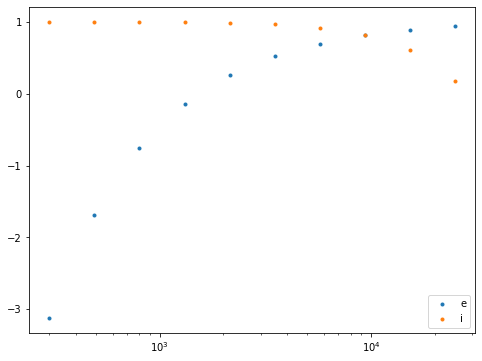

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(Te_eV_list*eV_to_K, np.gradient(Pe_list,Te_eV_list), '.', label='e')
# ax.plot(Te_eV_list*eV_to_K, np.gradient(Pi_list,Te_eV_list), '.', label='i')

ax.plot(Te_eV_list*eV_to_K, Pe_list, '.', label='e')
ax.plot(Te_eV_list*eV_to_K, Pi_list, '.', label='i')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()

In [15]:
u_matrix = atom.hnc.βu_r_matrix*atom.hnc.Temp_matrix[:,:,np.newaxis]
r = atom.hnc.r_array
np.gradient(u_matrix, r, axis=2)

array([[[-4.49483425e+02, -2.99655616e+02, -1.12370856e+02, ...,
         -3.62482248e-03, -3.61030863e-03, -3.60307355e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.49679458e-03,  2.48679737e-03,  2.48181381e-03]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.49679458e-03,  2.48679737e-03,  2.48181381e-03],
        [-1.82463522e+00, -1.78519283e+00, -1.70908408e+00, ...,
         -1.71979655e-03, -1.71291045e-03, -1.70947777e-03]]])

In [18]:
atom.r_c

0.3

In [16]:
atom.run_hnc()
# atom.get_cv(ε_derivative=1e-7, ε_table=1e-6)

0: Initial condition Total Error: 1.232e+00
Exiting status 0, reverting to best index so far: 170
Final iter:172, Total Error: 2.763e-07


In [17]:
atom.hnc.Pressure/(atom.qsp.Ti*atom.ni_cc * (1e2*aB)**3)

2.6325192305966776

In [10]:
atom.hnc.Peff_over_nkBT

AttributeError: 'HNC_solver' object has no attribute 'Peff_over_nkBT'

In [11]:
atom.get_effective_ion_cp()

0: Initial condition Total Error: 2.023e-01
Exiting status 0, reverting to best index so far: 147
Final iter:149, Total Error: 4.617e-07
0: Initial condition Total Error: 1.914e-01
Exiting status 0, reverting to best index so far: 146
Final iter:148, Total Error: 4.773e-07
0: Initial condition Total Error: 2.049e-01
Exiting status 0, reverting to best index so far: 147
Final iter:149, Total Error: 4.650e-07
0: Initial condition Total Error: 1.937e-01
Exiting status 0, reverting to best index so far: 146
Final iter:148, Total Error: 4.808e-07

_____________________________
Heat Capacity Results (Effective Ion Picture) 
c_p = 6.316e+03 [J/m^3/K] = 6.316e+04 [erg/cc/K]
c_p^ideal = 4.315e+03 [J/m^3/K] = 4.315e+04 [erg/cc/K]
c_v = 3.387e+03 [J/m^3/K] = 3.387e+04 [erg/cc/K]

γ = cp/cv = 1.865e+00

E/nkBT = 2.187, P/nkBT = 1.897 
cp/nkB = 3.660, cv/nkB = 1.962 

Total cv/nkB estimate (add ideal electrons):
c_v_tot_estimate = 1.689


In [ ]:
# r_c = 0.1
Heat Capacity Results 
c^e_v = 3.261e+03 [J/m^3/K], c^i_v  = 3.512e+04 [J/m^3/K] 
c_v = 3.838e+04 [J/m^3/K] 

c^e_v/(ne kB)= 0.279 , c^i_v/(ni kB)   = 1.390 
c_v/(n kB) = 1.039  

In [ ]:
# r_c = 0
Heat Capacity Results 
c^e_v = 1.864e+03 [J/m^3/K], c^i_v  = 3.508e+04 [J/m^3/K] 
c_v = 3.695e+04 [J/m^3/K] 

c^e_v/(ne kB)= 0.160 , c^i_v/(ni kB)   = 1.389 
c_v/(n kB) = 1.000 

In [6]:
atom.get_effective_ion_cp()

0: Initial condition Total Error: 2.440e-03
Exiting status 0, reverting to best index so far: 6
Final iter:8, Total Error: 5.909e-09
0: Initial condition Total Error: 4.382e-03
Exiting status 0, reverting to best index so far: 8
Final iter:10, Total Error: 6.985e-09
0: Initial condition Total Error: 4.456e-03
Exiting status 0, reverting to best index so far: 8
Final iter:10, Total Error: 8.409e-09
0: Initial condition Total Error: 2.368e-03
Exiting status 0, reverting to best index so far: 6
Final iter:8, Total Error: 5.476e-09

_____________________________
Heat Capacity Results (Effective Ion Picture) 
c_p = 3.103e+04 [J/m^3/K] = 3.103e+05 [erg/cc/K]
c_p^ideal = 2.071e+04 [J/m^3/K] = 2.071e+05 [erg/cc/K]
c_v = 1.801e+04 [J/m^3/K] = 1.801e+05 [erg/cc/K]

γ = cp/cv = 1.723e+00

E/nkBT = 2.027, P/nkBT = 1.637 
cp/nkB = 3.746, cv/nkB = 2.174 
Total cv/nkB estimate (add ideal electrons):
c_v_tot_estimate = 1.837
